<a href="https://colab.research.google.com/github/LinearPi/ClassDoc/blob/master/STR_inference%2C_for_screen_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Deep Text Recognition benchmark](https://github.com/clovaai/deep-text-recognition-benchmark)

In [0]:
!pip3 install torch==1.1.0
!pip3 install lmdb pillow torchvision nltk

In [0]:
import os
import time
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/clovaai/deep-text-recognition-benchmark.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  !git clone -q {git_repo_url}
  !cd {project_name}
  
import sys  
sys.path.append(project_name)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
pretrained_model_path = "./pretrained_model/"
if not exists(pretrained_model_path):
  !mkdir {pretrained_model_path}

# https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory
links = [
    ("best_accuracy.pth", "1b59rXuGGmKne1AuHnkgDzoYgKeETNMv9"),
    ("case-sensitive.pth", "1ajONZOgiG9pEYsQ-eBmgkVbMDuHgPCaY")
]
for counter, item in enumerate(links):
  filename = item[0]
  fileid   = item[1]
  downloaded = drive.CreateFile({'id': fileid})
  downloaded.GetContentFile("./pretrained_model/"+filename)

downloaded = drive.CreateFile({'id': "1A80_kUT-z0Jv-KnFzItaCR_FuPxHr4Yv"})
downloaded.GetContentFile("./numbers.zip")
!unzip numbers.zip


downloaded = drive.CreateFile({'id': "1mJDJIHK0klLdI2HtYApz4TGyl9ZL64J2"})
downloaded.GetContentFile("./test.zip")
!unzip test.zip

Archive:  numbers.zip
replace numbers/0a3f6915-c041-4005-bbf7-0ca2baf93bd2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: numbers/0a3f6915-c041-4005-bbf7-0ca2baf93bd2.png  
  inflating: numbers/0a259d51-3b11-4aff-abd3-e259c57977d0.png  
  inflating: numbers/0a3768b6-0ab6-4b3b-ba75-d2ae84b6781d.png  
  inflating: numbers/0ac3e137-b591-4a59-ac32-70dca9c6aabe.png  
  inflating: numbers/0af780c2-c254-4dc8-b9bf-4f5d81a077e2.png  
  inflating: numbers/0b8772da-5dc5-4847-8a24-f9e1ca2ed18a.png  
  inflating: numbers/0c31ffd9-1864-4553-b7ea-402d3b6bb4a6.png  
  inflating: numbers/0c87995b-c9d7-4b7d-9cf9-6f2750462e00.png  
  inflating: numbers/0cd147e2-7c82-4506-8d33-6b4f70bcec3c.png  
  inflating: numbers/0cf72ffa-c3dd-42fd-ab02-2e33c6619306.png  
Archive:  test.zip
replace test/image_3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/image_3.png        
  inflating: test/image_2.png        
  inflating: test/image_1.png        
  inflating: test/image_4.png        


In [0]:
import os
import time
import string
import argparse

import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import numpy as np
from nltk.metrics.distance import edit_distance

from utils import CTCLabelConverter, AttnLabelConverter, Averager
from dataset import hierarchical_dataset, AlignCollate
from model import Model

In [0]:
!export CUDA_VISIBLE_DEVICES=0
parser = argparse.Namespace()
parser.eval_data=True
parser.benchmark_all_eval='store_true'
parser.workers=4
parser.batch_size=192
parser.saved_model='./pretrained_model/case-sensitive.pth'
""" Data processing """
parser.batch_max_length=25
parser.imgH=32
parser.imgW=100
parser.rgb='store_true'
parser.character='0123456789abcdefghijklmnopqrstuvwxyz'
parser.sensitive='store_true'
parser.PAD='store_true'
""" Model Architecture """
parser.Transformation='TPS'
parser.FeatureExtraction='ResNet'
parser.SequenceModeling='BiLSTM'
parser.Prediction='Attn'
parser.num_fiducial=20
parser.input_channel=1
parser.output_channel=512
parser.hidden_size=256
parser.num_gpu=0

opt = parser
print(opt)

""" vocab / character number configuration """
opt.character = string.printable[:-6]  # same with ASTER setting (use 94 char).

cudnn.benchmark = True
cudnn.deterministic = True
opt.num_gpu = torch.cuda.device_count()

print(opt.character)

Namespace(FeatureExtraction='ResNet', PAD='store_true', Prediction='Attn', SequenceModeling='BiLSTM', Transformation='TPS', batch_max_length=25, batch_size=192, benchmark_all_eval='store_true', character='0123456789abcdefghijklmnopqrstuvwxyz', eval_data=True, hidden_size=256, imgH=32, imgW=100, input_channel=1, num_fiducial=20, num_gpu=0, output_channel=512, rgb='store_true', saved_model='./pretrained_model/case-sensitive.pth', sensitive='store_true', workers=4)
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [0]:
if 'CTC' in opt.Prediction:
    converter = CTCLabelConverter(opt.character)
else:
    converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)

In [0]:
opt.input_channel = 1
model = Model(opt)
print('model input parameters', opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel,
      opt.hidden_size, opt.num_class, opt.batch_max_length, opt.Transformation, opt.FeatureExtraction,
      opt.SequenceModeling, opt.Prediction)
model = torch.nn.DataParallel(model).cuda()

model input parameters 32 100 20 1 512 256 96 25 TPS ResNet BiLSTM Attn


In [0]:
print('loading pretrained model from %s' % opt.saved_model)
model.load_state_dict(torch.load(opt.saved_model))
opt.experiment_name = '_'.join(opt.saved_model.split('/')[1:])

loading pretrained model from ./pretrained_model/case-sensitive.pth


In [0]:
os.makedirs(f'./result/{opt.experiment_name}', exist_ok=True)
os.system(f'cp {opt.saved_model} ./result/{opt.experiment_name}/')

0

In [0]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=0).cuda() 
#model.eval()

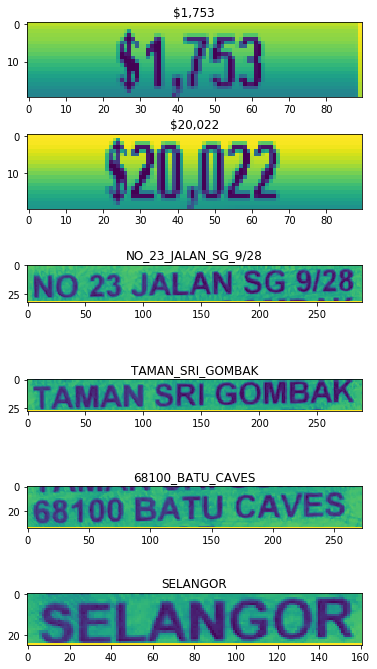

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

test_images = [
    ("./numbers/0a259d51-3b11-4aff-abd3-e259c57977d0.png", "$1,753" ),
    ("./numbers/0ac3e137-b591-4a59-ac32-70dca9c6aabe.png", "$20,022"),
    ("./test/image_1.png", "NO_23_JALAN_SG_9/28"),
    ("./test/image_2.png", "TAMAN_SRI_GOMBAK"   ),
    ("./test/image_3.png", "68100_BATU_CAVES"   ),
    ("./test/image_4.png", "SELANGOR"           ),
]

input_datas = []

n_images = len(test_images)
fig = plt.figure(figsize=(1,2))
fig.suptitle("")
for n, (imagepath, label) in enumerate(test_images):
  a = fig.add_subplot(np.ceil(n_images/float(1)), 1, n + 1)
  image = Image.open(imagepath).convert('L')
  plt.imshow(image)
  a.set_title(label)
  input_datas.append((image, label))
fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [0]:
from dataset import AlignCollate
_AlignCollate = AlignCollate(imgH=opt.imgH, imgW=opt.imgW)
image_tensors, labels = _AlignCollate(input_datas)

print(labels)

('$1,753', '$20,022', 'NO_23_JALAN_SG_9/28', 'TAMAN_SRI_GOMBAK', '68100_BATU_CAVES', 'SELANGOR')


In [0]:
evaluation_loader = torch.utils.data.DataLoader(
            input_datas, batch_size=2,
            shuffle=False,
            num_workers=int(opt.workers),
            collate_fn=_AlignCollate, pin_memory=True)

In [0]:
max_length = 10
for i, (cpu_images, cpu_texts) in enumerate(evaluation_loader):
  batch_size = cpu_images.size(0)
  length_of_data = 0 + batch_size
  with torch.no_grad():
    image = cpu_images.cuda()
    length_for_pred = torch.cuda.IntTensor([max_length] * batch_size)
    text_for_pred = torch.cuda.LongTensor(batch_size, max_length + 1).fill_(0)
    text_for_loss, length_for_loss = converter.encode(cpu_texts)
  
  preds = model(image, text_for_pred, is_train=False)
  preds = preds[:, :text_for_loss.shape[1] - 1, :]
  target = text_for_loss[:, 1:]  # without [GO] Symbol
  _, preds_index = preds.max(2)
  
  sim_preds = converter.decode(preds_index, length_for_pred)
  sim_preds = list(map(lambda s: s.replace("[s]","").replace("[GO]",""), sim_preds))
  print("exact labels", cpu_texts)
  print("predicted   ", sim_preds)
  #cpu_texts = converter.decode(text_for_loss[:, 1:], length_for_loss)
  #print("cpu_texts", cpu_texts)

exact labels ['$1,753', '$20,022']
predicted    ['st,3-1', '$20,022']
exact labels ['NO_23_JALAN_SG_9/28', 'TAMAN_SRI_GOMBAK']
predicted    ['IZZAISE', 'TANCOMBA']
exact labels ['68100_BATU_CAVES', 'SELANGOR']
predicted    ['EXMBATUCAVES', 'SELANGOR']
